Classifying Synthetic Sequences - The Square Model
=====================================================

Download these utility functions first and place them in the same directory as this notebook. 

In [2]:
from IPython.display import FileLink, FileLinks

In [3]:
FileLink('plots.py')

c:\Users\wei\jupyter_book\cits4012\cits4012_natural_language_processing\cits4012_natural_language_processing\rnn\plots.py

In [4]:
FileLink('util.py')

c:\Users\wei\jupyter_book\cits4012\cits4012_natural_language_processing\cits4012_natural_language_processing\rnn\util.py

In [5]:
FileLink('replay.py')

c:\Users\wei\jupyter_book\cits4012\cits4012_natural_language_processing\cits4012_natural_language_processing\rnn\replay.py

## Setting Up

In [8]:
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torch.nn.utils import rnn as rnn_utils
from util import StepByStep
from plots import *

## Data Generation

In [4]:
import numpy as np

def generate_sequences(n=128, variable_len=False, seed=13):
    basic_corners = np.array([[-1, -1], [-1, 1], [1, 1], [1, -1]])
    np.random.seed(seed)
    bases = np.random.randint(4, size=n)
    if variable_len:
        lengths = np.random.randint(3, size=n) + 2
    else:
        lengths = [4] * n
    directions = np.random.randint(2, size=n)
    points = [basic_corners[[(b + i) % 4 for i in range(4)]][slice(None, None, d*2-1)][:l] + np.random.randn(l, 2) * 0.1 for b, d, l in zip(bases, directions, lengths)]
    return points, directions

## Data Generation

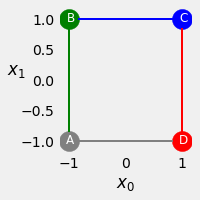

In [9]:
fig = counter_vs_clock(draw_arrows=False)

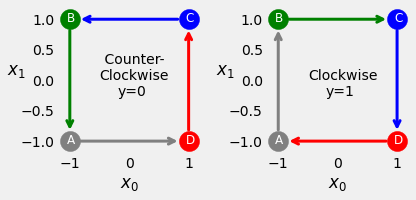

In [10]:
fig = counter_vs_clock()

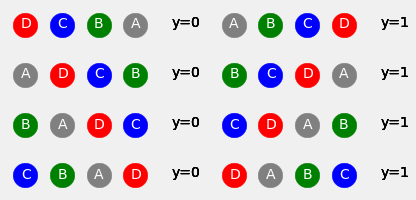

In [11]:
fig = plot_sequences()

In [12]:
points, directions = generate_sequences(n=128, seed=13)

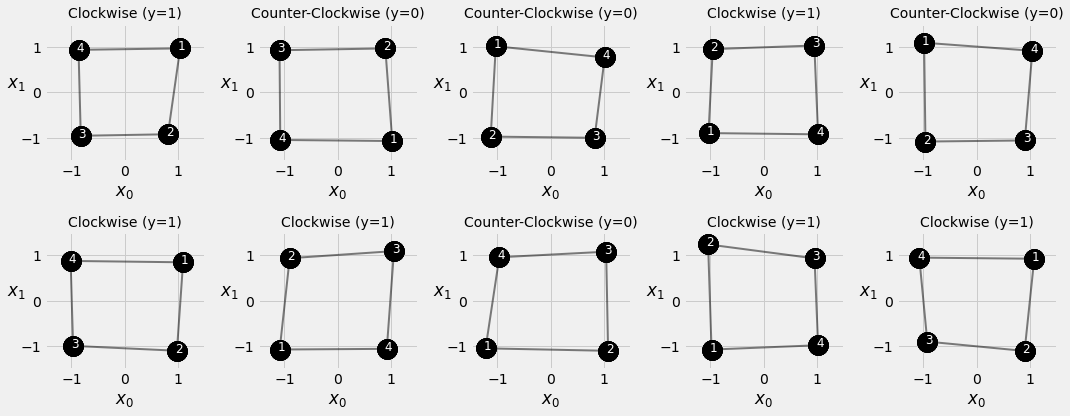

In [13]:
fig = plot_data(points, directions)

## Square Model

### Data Generation

In [14]:
test_points, test_directions = generate_sequences(seed=19)

### Data Preparation

In [15]:
train_data = TensorDataset(torch.as_tensor(points).float(), 
                           torch.as_tensor(directions).view(-1, 1).float())
test_data = TensorDataset(torch.as_tensor(test_points).float(),
                          torch.as_tensor(test_directions).view(-1, 1).float())

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16)

### Model Configuration

In [17]:
class SquareModel(nn.Module):
    def __init__(self, n_features, hidden_dim, n_outputs):
        super(SquareModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.hidden = None
        # Simple RNN
        self.basic_rnn = nn.RNN(self.n_features, self.hidden_dim, batch_first=True)
        # Classifier to produce as many logits as outputs
        self.classifier = nn.Linear(self.hidden_dim, self.n_outputs)
                
    def forward(self, X):
        # X is batch first (N, L, F)
        # output is (N, L, H)
        # final hidden state is (1, N, H)
        batch_first_output, self.hidden = self.basic_rnn(X)
        
        # only last item in sequence (N, 1, H)
        last_output = batch_first_output[:, -1]
        # classifier will output (N, 1, n_outputs)
        out = self.classifier(last_output)
        
        # final output is (N, n_outputs)
        return out.view(-1, self.n_outputs)

In [18]:
torch.manual_seed(21)
model = SquareModel(n_features=2, hidden_dim=2, n_outputs=1)
loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

### Model Training

The StepByStep class encapsulated the training routine as well as the data loading into methods such as:

- `_mini_batch`
- `_make_train_step`
- `_make_val_step`

You may want to take a closer look at the `StepByStep` in the `util.py` file to learn how to factorize your code into a reusable blocks. 

In [20]:
sbs_rnn = StepByStep(model, loss, optimizer)
sbs_rnn.set_loaders(train_loader, test_loader)
sbs_rnn.train(100)

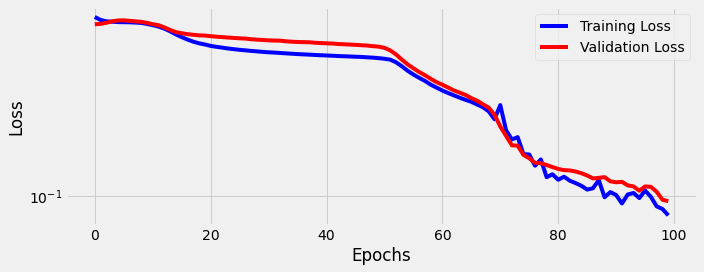

In [22]:
fig = sbs_rnn.plot_losses()

In [23]:
StepByStep.loader_apply(test_loader, sbs_rnn.correct)

tensor([[50, 53],
        [75, 75]])

## Visualizing the Model

### Transformed Inputs

In [24]:
state = model.basic_rnn.state_dict()
state['weight_ih_l0'], state['bias_ih_l0']

(tensor([[-0.5153, -2.6577],
         [-1.7006, -0.4970]], device='cuda:0'),
 tensor([0.8069, 0.8827], device='cuda:0'))

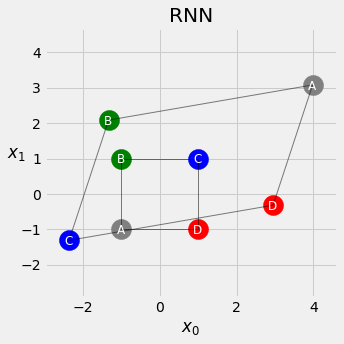

In [25]:
fig = figure13(model.basic_rnn)

### Hidden States

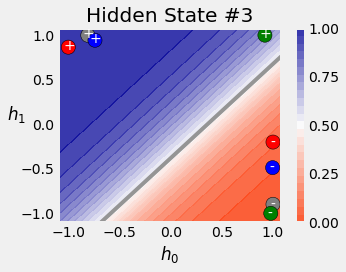

In [26]:
fig = canonical_contour(model)

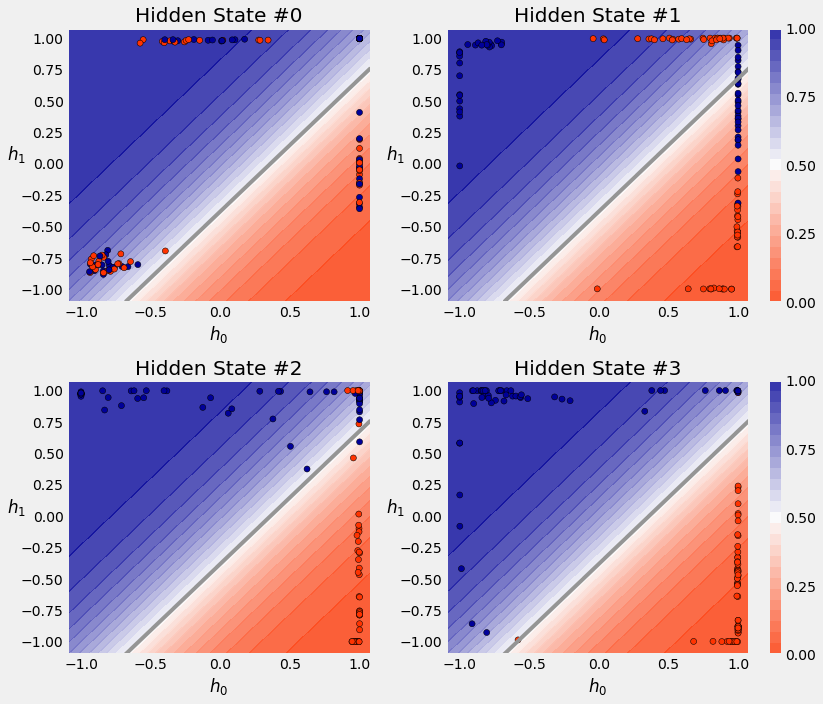

In [27]:
fig = hidden_states_contour(model, points, directions)

### The Journey of a Hidden State

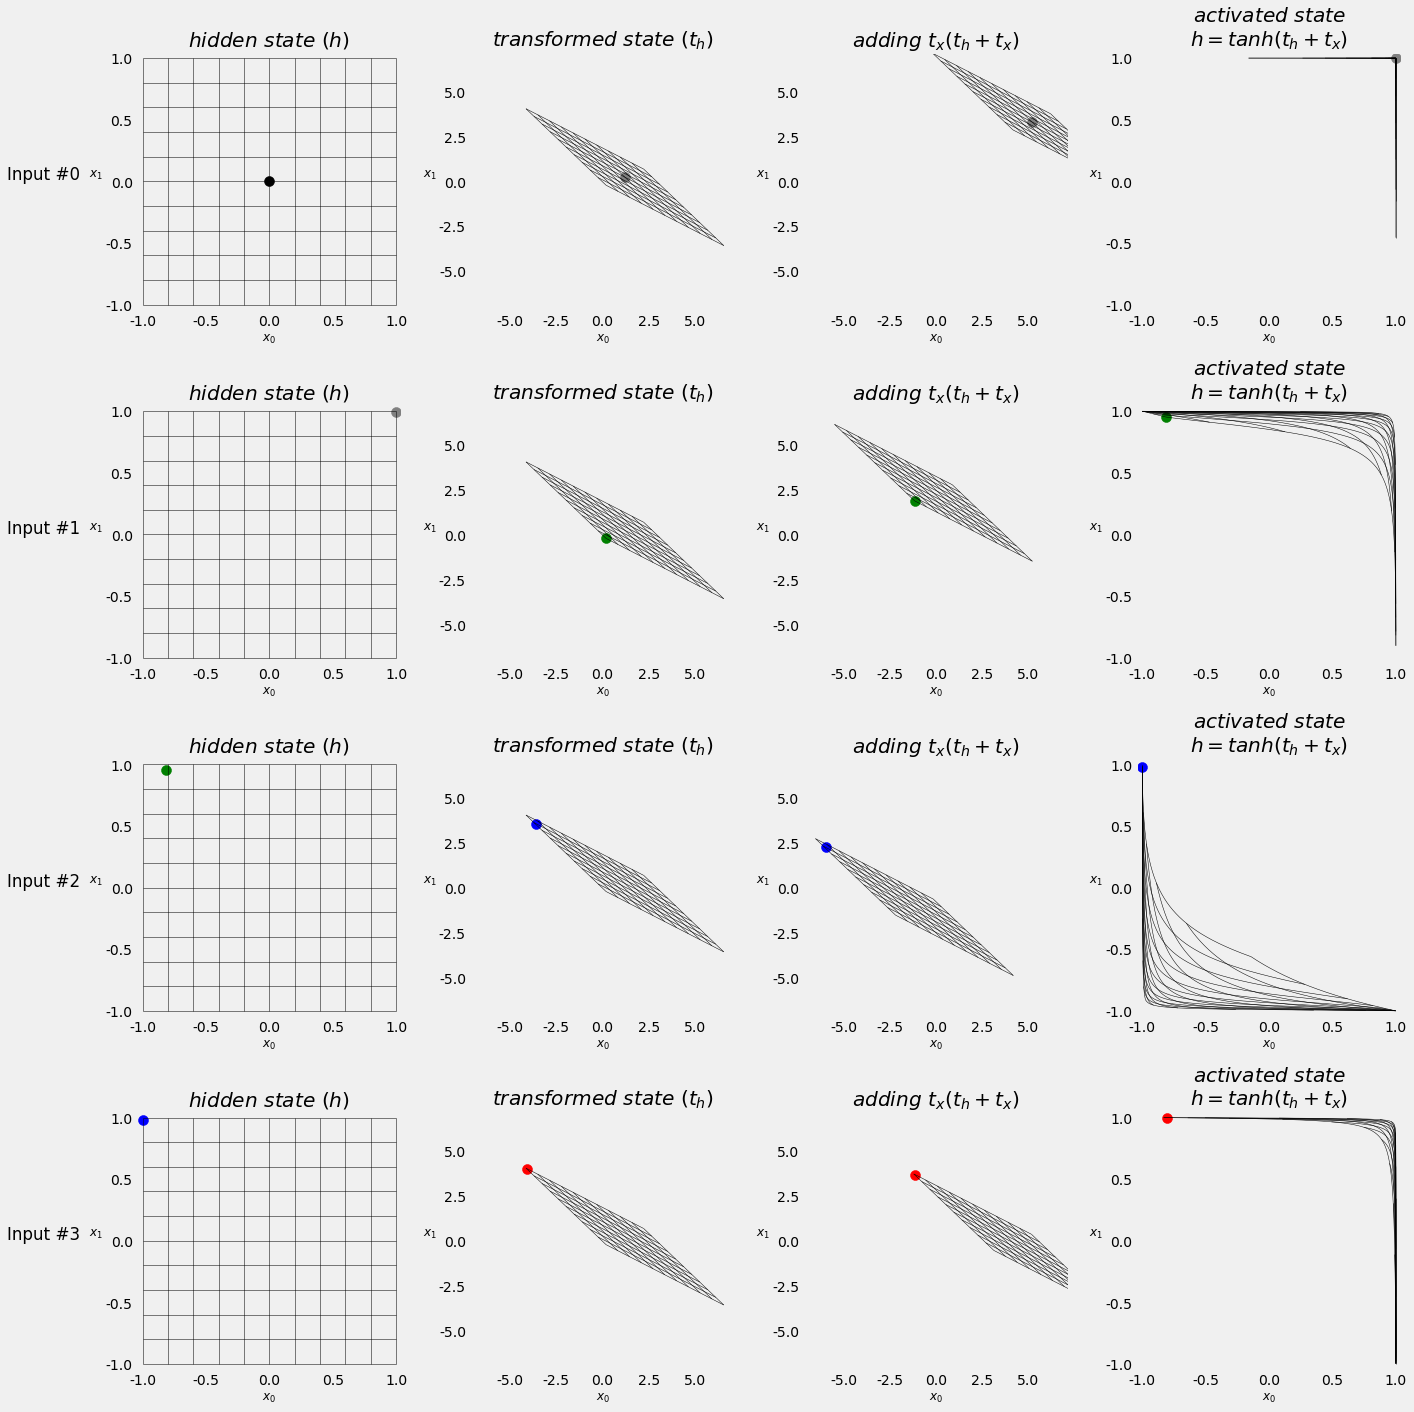

In [28]:
fig = figure16(model.basic_rnn)

In [29]:
square = torch.tensor([[-1, -1], [-1, 1], [1, 1], [1, -1]]).float().view(1, 4, 2)
model(square.to(sbs_rnn.device))
model.hidden

tensor([[[-0.8091,  0.9987]]], device='cuda:0', grad_fn=<CudnnRnnBackward>)

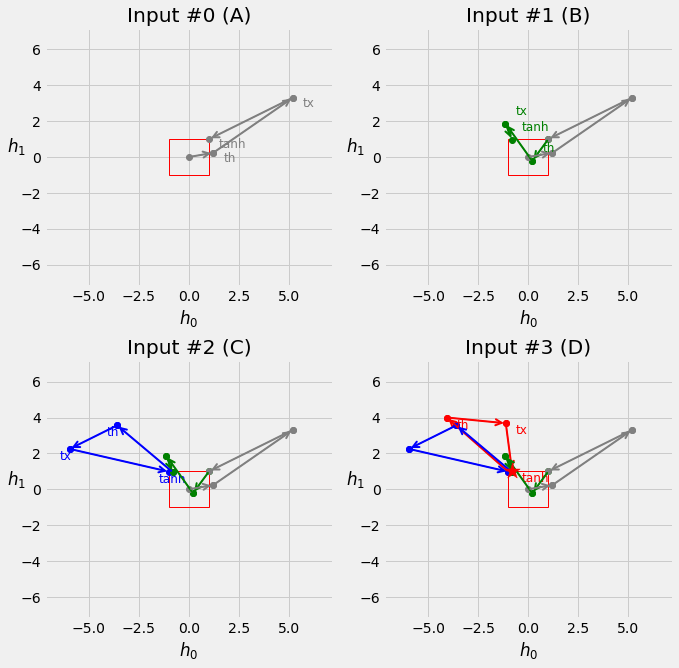

In [30]:
fig = figure17(model.basic_rnn)